## Library Import

In [4]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNet
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.models import load_model

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

## Data Preprocessing

In [2]:
file_path = r'D:\Synapsis\FMD_DATASET'
categories = os.listdir(file_path)

labels = [i for i in range (len(categories))]
label_dict = dict(zip(categories, labels))

In [3]:
sub_categories = []

for category in categories:
    sub_path = os.path.join(file_path, category)
    sub = os.listdir(sub_path)

    sub_categories.append(sub)

categories_dict = dict(zip(categories, sub_categories))

In [4]:
img_size = 128
feature = []
target = []

for category, sub_categories in categories_dict.items():
    for sub_name in sub_categories:
        sub_path = os.path.join(file_path, category, sub_name)
        img_names = os.listdir(sub_path)
        
        for img_name in img_names:
            img_path = os.path.join(sub_path, img_name)
            img = cv2.imread(img_path)

            # Resized
            resized = cv2.resize(img ,(img_size, img_size))

            # Collect all the normalized img and label to holder
            feature.append(resized)
            target.append(label_dict[category])
        

In [5]:
print(f'total feature : {len(feature)} & total target : {len(target)}')

total feature : 14536 & total target : 14536


In [6]:
new_feature = np.array(feature)/255.0
new_feature = np.reshape(new_feature, (new_feature.shape[0], img_size, img_size, 3))

target = np.array(target)
new_target = np_utils.to_categorical(target)

In [7]:
np.save('new_feature_2', new_feature)
np.save('new_target_2', new_target)

In [8]:
print("Feature Shape: ", new_feature.shape)
print("Target Shape : ", new_target.shape)

Feature Shape:  (14536, 128, 128, 3)
Target Shape :  (14536, 3)


## Deep Learning

### Split the Dataset

In [9]:
new_feature = np.load('new_feature_2.npy')
new_target = np.load('new_target_2.npy')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(new_feature, new_target, stratify = new_target, test_size= 0.2, random_state = 42)

In [11]:
print('X_train shape : ', X_train.shape)
print('X_test shape : ', X_test.shape)
print('y_train shape : ', y_train.shape)
print('y_test shape : ', y_test.shape)

X_train shape :  (11628, 128, 128, 3)
X_test shape :  (2908, 128, 128, 3)
y_train shape :  (11628, 3)
y_test shape :  (2908, 3)


### Data Augmentation

In [12]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

### Model Training

In [13]:
base_model = MobileNet(input_shape=[img_size,img_size,3], weights = "imagenet", include_top=False)

base_model.trainable = False

model = Flatten()(base_model.output)
model = Dense(units=256, activation="relu")(model)
model = Dense(units=64, activation="relu")(model)
prediction_layer = Dense(units=3, activation="softmax")(model)

model = Model(inputs = base_model.input, outputs = prediction_layer)
model.compile(optimizer='SGD',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
history =  model.fit(aug.flow(X_train, y_train, batch_size= 64), epochs= 10, validation_data = (X_test, y_test))

Epoch 1/10
182/182 [==============================] - 74s 391ms/step - loss: 0.3382 - accuracy: 0.9097 - val_loss: 0.0927 - val_accuracy: 0.9697
Epoch 2/10
182/182 [==============================] - 71s 388ms/step - loss: 0.1104 - accuracy: 0.9613 - val_loss: 0.0863 - val_accuracy: 0.9704
Epoch 3/10
182/182 [==============================] - 71s 391ms/step - loss: 0.0940 - accuracy: 0.9667 - val_loss: 0.0826 - val_accuracy: 0.9725
Epoch 4/10
182/182 [==============================] - 71s 389ms/step - loss: 0.0845 - accuracy: 0.9691 - val_loss: 0.0787 - val_accuracy: 0.9742
Epoch 5/10
182/182 [==============================] - 66s 364ms/step - loss: 0.0797 - accuracy: 0.9715 - val_loss: 0.0832 - val_accuracy: 0.9708
Epoch 6/10
182/182 [==============================] - 65s 358ms/step - loss: 0.0691 - accuracy: 0.9751 - val_loss: 0.0782 - val_accuracy: 0.9749
Epoch 7/10
182/182 [==============================] - 64s 351ms/step - loss: 0.0664 - accuracy: 0.9768 - val_loss: 0.0920 - val_ac

In [15]:
model.save('model_MobileNet.model')

INFO:tensorflow:Assets written to: model_MobileNet.model\assets


INFO:tensorflow:Assets written to: model_MobileNet.model\assets


### Model Evaluation

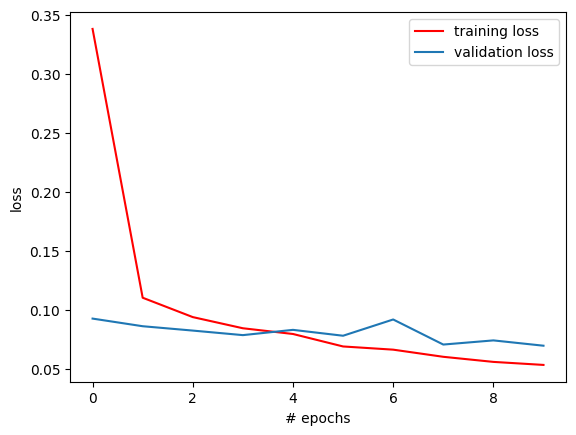

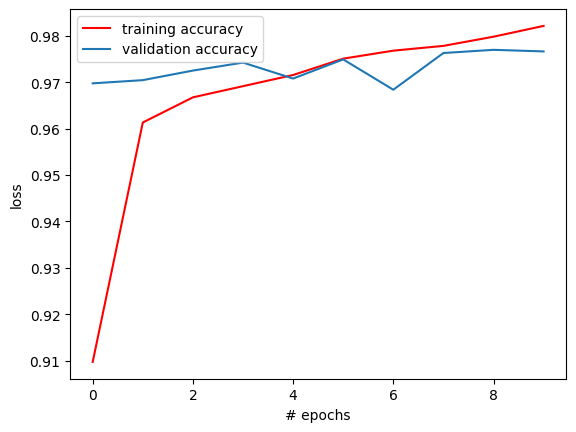

In [16]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [17]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

91/91 [==============================] - 13s 133ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.98      0.97      0.98       950
           2       0.96      0.98      0.97       958

    accuracy                           0.98      2908
   macro avg       0.98      0.98      0.98      2908
weighted avg       0.98      0.98      0.98      2908



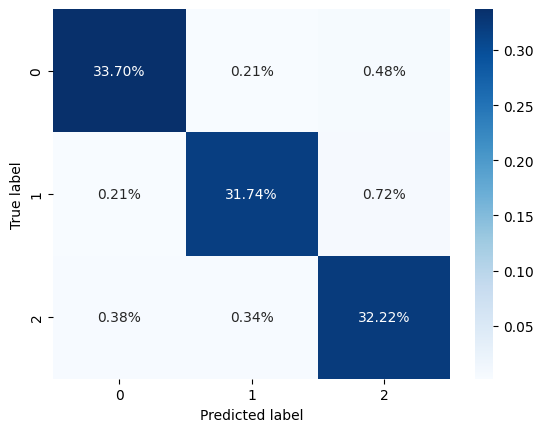

In [18]:
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

sn.heatmap(conf_matrix/np.sum(conf_matrix), annot= True, fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Predict

In [11]:
model = load_model('model_MobileNet.model')
face_class = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

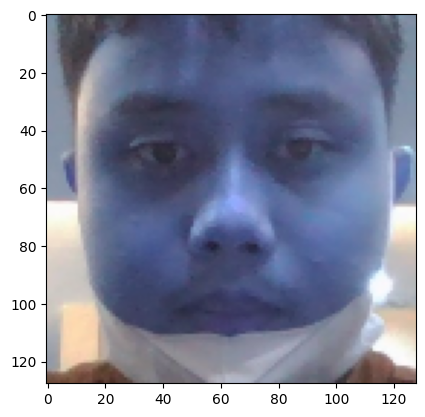

1/1 [==============================] - 0s 31ms/step
incorrect_mask


In [179]:
path = 'D:/Synapsis/For Testing/Incorrect_Mask.jpg'
test_img = cv2.imread(path)

try :
    face = face_class.detectMultiScale(test_img)
    x, y, w, h = list(face[0])
    test_img = test_img[y:y+w,x:x+w]

except:
    final_img = cv2.resize(test_img,(img_size, img_size))
    test_feature = np.array(final_img)/255.0
    test_feature = np.reshape(test_feature, ( 1, 128, 128, 3))

else :
    final_img = cv2.resize(test_img,(img_size, img_size))
    test_feature = np.array(final_img)/255.0
    test_feature = np.reshape(test_feature, ( 1, 128, 128, 3))
    
finally:
    plt.imshow(final_img)
    plt.show()

    result= model.predict(test_feature)
    label= np.argmax(result,axis=1)[0]
    print(list(label_dict.keys())[label])

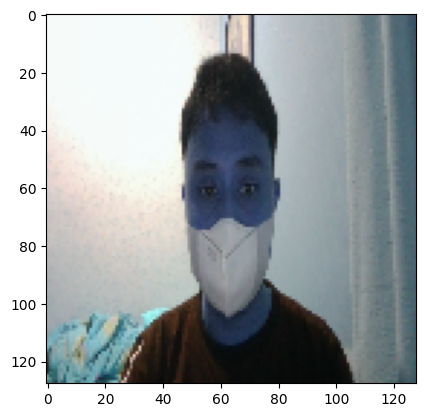

1/1 [==============================] - 0s 305ms/step
with_mask


In [181]:
path = 'D:/Synapsis/For Testing/With_Mask_test.jpg'
test_img = cv2.imread(path)

try :
    face = face_class.detectMultiScale(test_img)
    x, y, w, h = list(face[0])
    test_img = test_img[y:y+w,x:x+w]

except:
    final_img = cv2.resize(test_img,(img_size, img_size))
    test_feature = np.array(final_img)/255.0
    test_feature = np.reshape(test_feature, ( 1, 128, 128, 3))

else :
    final_img = cv2.resize(test_img,(img_size, img_size))
    test_feature = np.array(final_img)/255.0
    test_feature = np.reshape(test_feature, ( 1, 128, 128, 3))
    
finally:
    plt.imshow(final_img)
    plt.show()

    result= model.predict(test_feature)
    label= np.argmax(result,axis=1)[0]
    print(list(label_dict.keys())[label])

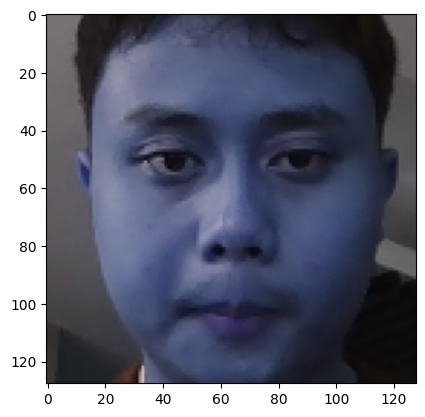

1/1 [==============================] - 0s 28ms/step
without_mask


In [182]:
path = 'D:/Synapsis/For Testing/No_Mask.jpg'
test_img = cv2.imread(path)


try :
    face = face_class.detectMultiScale(test_img)
    x, y, w, h = list(face[0])
    test_img = test_img[y:y+w,x:x+w]

except:
    final_img = cv2.resize(test_img,(img_size, img_size))
    test_feature = np.array(final_img)/255.0
    test_feature = np.reshape(test_feature, ( 1, 128, 128, 3))

else :
    final_img = cv2.resize(test_img,(img_size, img_size))
    test_feature = np.array(final_img)/255.0
    test_feature = np.reshape(test_feature, ( 1, 128, 128, 3))
    
finally:
    plt.imshow(final_img)
    plt.show()

    result= model.predict(test_feature)
    label= np.argmax(result,axis=1)[0]
    print(list(label_dict.keys())[label])